In [65]:
import numpy as np
import xarray
import pymc as pm
import pymc.dims as pmd
import arviz as az

months = [1, 2, 3, 4, 5, 6]
years = 2000+np.arange(10)
coords  = {'year': years, 'month': months}

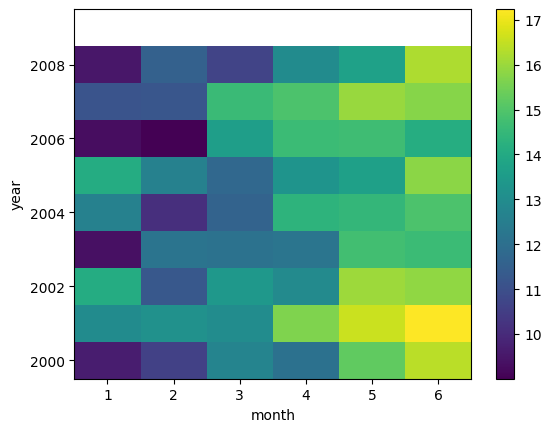

In [66]:

month_offset = xarray.DataArray(data=np.arange(6), coords={'month': months}, dims='month')
year_offsets = xarray.DataArray(data=pm.draw(pm.Normal.dist(10, 1),len(years)), coords={'year': coords['year']}, dims='year')
# Set last year offset to nan
year_offsets.loc[years[-1]] = np.nan
y_obs = pm.draw(pmd.Normal.dist(year_offsets + month_offset, 1.))
y_obs = xarray.DataArray(data=y_obs, coords=coords)
y_obs.plot()


[nan nan nan nan nan nan]


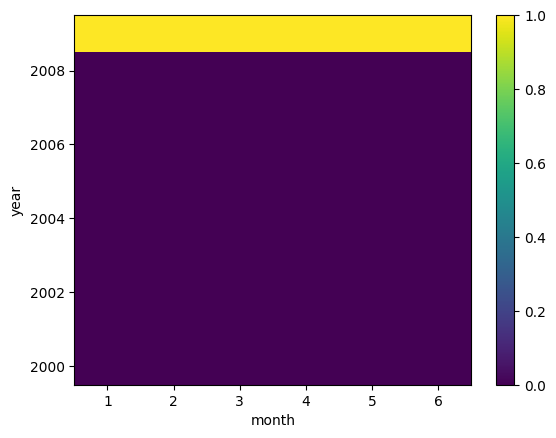

In [67]:
missing_mask = y_obs.isnull()
missing_mask.plot()
print(y_obs.values[missing_mask.values])

In [68]:
# Set last year
with pm.Model(coords=coords) as model:
    mu = pmd.Normal('mu', 0, 10, dims=())
    year_mu = pmd.Normal('year_mu', mu=mu, sigma=1, dims=('year',))
    full_mu = year_mu + month_offset
    pm.Normal('obs_y', mu=full_mu.values[~missing_mask.values], sigma=1, observed=y_obs.values[~missing_mask.values])
    y = pmd.Normal('y', mu=full_mu, sigma=1, dims=('year', 'month'))
    idata = pm.sample()
    posterior_predicitve = pm.sample_posterior_predictive(idata, var_names=['y'])



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, year_mu, y]


/Users/knutdr/Sources/chap_pymc/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Sampling: [y]


/Users/knutdr/Sources/chap_pymc/.venv/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

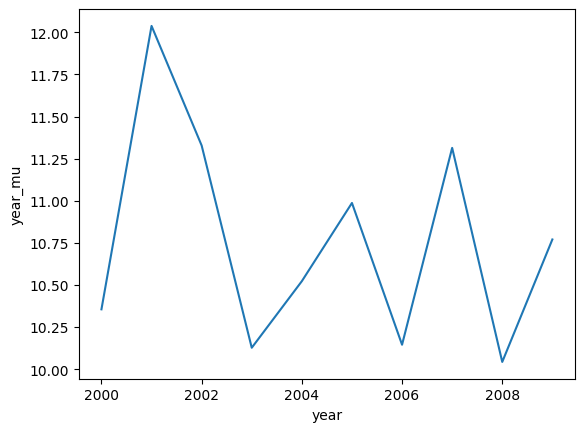

In [69]:
idata.posterior['year_mu'].mean(dim=['chain', 'draw']).plot()

In [70]:
#idata['y'].mean(dim=['chain', 'draw']).plot()

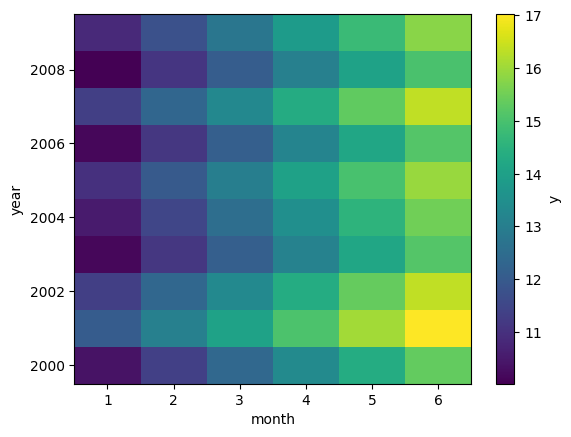

In [71]:
posterior_predicitve.posterior_predictive['y'].median(dim=['chain', 'draw']).plot()